In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

from fastprogress import master_bar, progress_bar
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from fastai.distributed import *
from fastai.metrics import accuracy
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
#import pretrainedmodels
import math
import sys
import pickle
from arch import RingGeMNet, GeMNet, L2Norm, GeM

from arch import GeM, L2Norm
%config InlineBackend.figure_format ='retina'

SEED = 42
np.random.seed(SEED), random.seed(SEED), torch.random.manual_seed(SEED), torch.cuda.manual_seed_all(SEED)

(None, None, <torch._C.Generator at 0x7f652101d070>, None)

In [2]:
path = Path('../google-landmark-train/')
train_df = pd.read_csv(path / 'train.csv', usecols=[0,2], converters={'id':lambda x:x[0]+'/'+x[1]+'/'+x[2]+'/'+x})
train_df.head()
min_images, n_landmarks = 200, 1000
train_df = train_df.groupby('landmark_id').filter(lambda x: len(x) >= min_images)

In [3]:
train_df = train_df[train_df['landmark_id'].isin(
    np.random.choice(train_df['landmark_id'].unique(), n_landmarks, replace=False))]

In [4]:
train_df.head()

,id,landmark_id
1,2/0/2/202cd79556f30760,104169
9,8/d/f/8df019949b8db328,81049
11,c/c/f/ccf070a2da242d56,138982
23,0/5/3/053d1409647dfba2,74821
25,3/c/d/3cdc355c6232712f,12877


In [5]:
train_df['target'] = 1
train1 = train_df.copy()
train1['target'] = 0
train_df = train_df.append(train1)

In [6]:
train_df.head()

,id,landmark_id,target
1,2/0/2/202cd79556f30760,104169,1
9,8/d/f/8df019949b8db328,81049,1
11,c/c/f/ccf070a2da242d56,138982,1
23,0/5/3/053d1409647dfba2,74821,1
25,3/c/d/3cdc355c6232712f,12877,1


In [7]:
mean, std = torch.tensor(imagenet_stats)
# The primary difference from the tutorial is with how normalization is being done here
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj = (img1, img2)
        self.data  = [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self): return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])


In [8]:
class SiamImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        match=1
        if i>=len(self.items)//2:#"First set of iteration will generate similar pairs, next will generate different pairs"
            match = 0
        fn = self.items[i]
        img1 = super().get(i) # Returns Image class object
        
        imgs = self.inner_df.id.values
        ids  = self.inner_df.landmark_id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) # Returns Image class object
        return SiamImage(img1, img2)
    
    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)


In [9]:
BS = 48
NUM_WORKERS = 31
SZ = 224

whl_tfms = get_transforms()
data = (SiamImageList.from_df(train_df, path, suffix='.jpg',cols=0)
         .split_by_rand_pct(valid_pct=0.2, seed=SEED)
         .label_from_df(cols='target', label_cls=FloatList)
         .transform(whl_tfms, size=SZ)
         .databunch(bs=BS, num_workers=NUM_WORKERS))


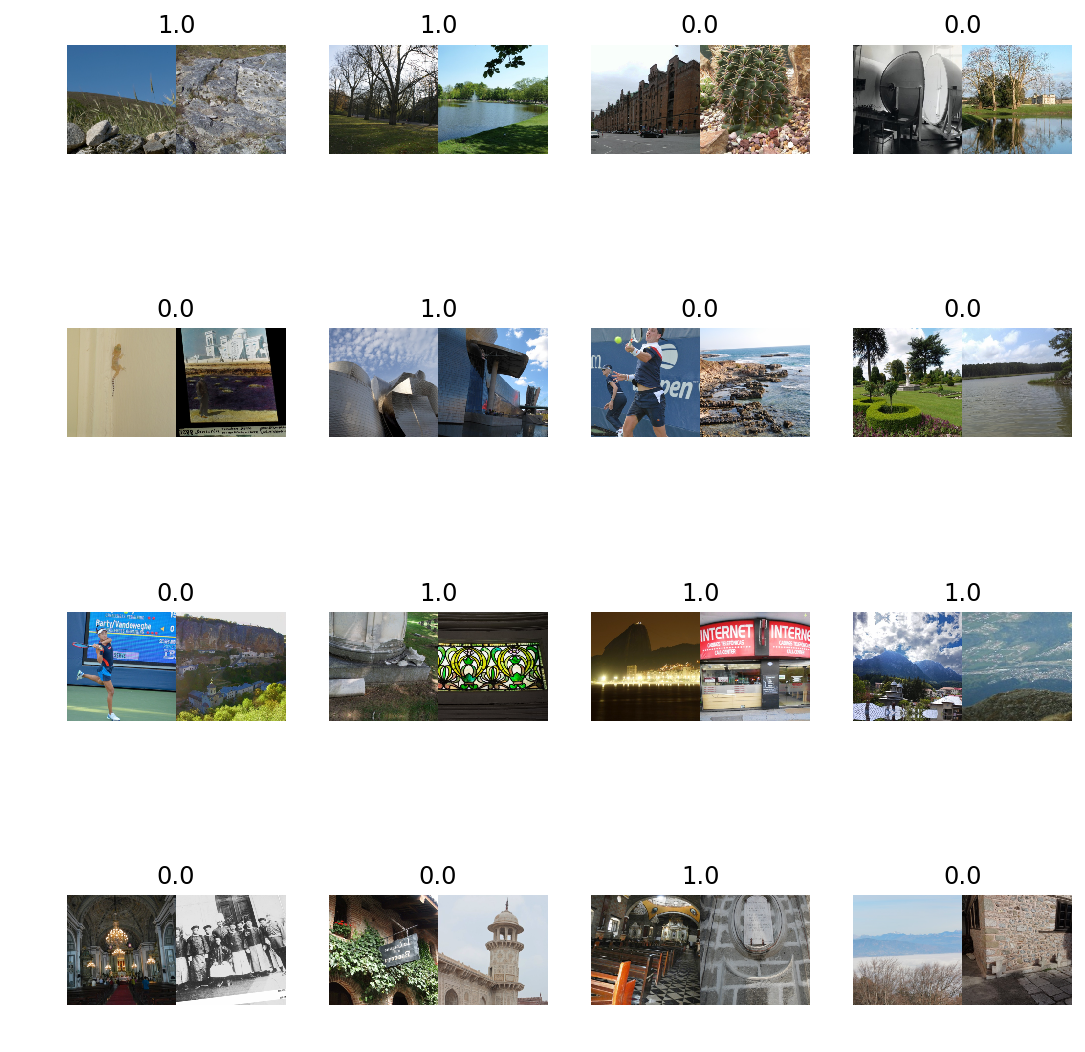

In [10]:
data.show_batch(4)


In [11]:
arch=models.resnet50

In [12]:
class SiameseNet(nn.Module):
    def __init__(self, arch):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            *list(list(arch(pretrained=True).children())[:-2]),
            nn.AdaptiveAvgPool2d(1),L2Norm(),Flatten())
                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2


In [13]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()


In [14]:
model = SiameseNet(arch)
siam_learner = Learner(data, model, loss_func=ContrastiveLoss(0.5))

In [15]:
siam_learner = siam_learner.to_fp16().to_parallel()

In [16]:
data.batch_size = 64

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


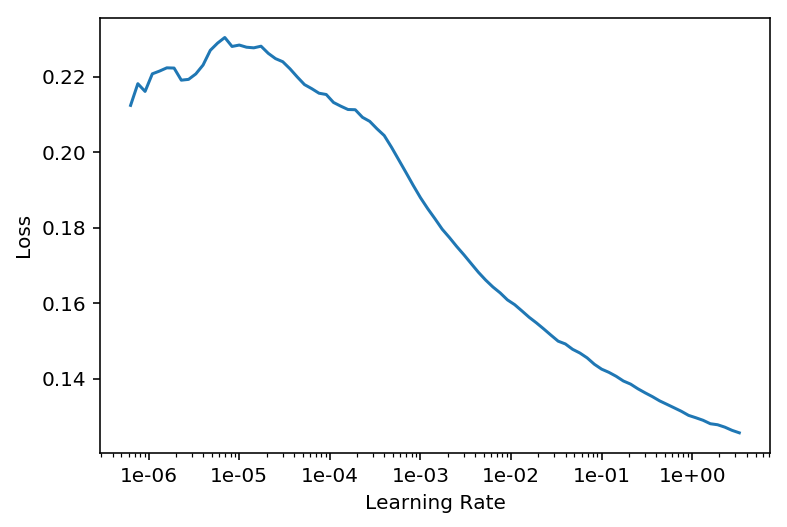

In [17]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [ ]:
siam_learner.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,time
0,0.085916,0.101041,2:46:47


In [ ]:
data.train_ds[0][0].img1

In [ ]:
data.train_ds[0][0].img1.data

In [ ]:
siam_learner.to_fp32().model.cnn(data.train_ds[0][0].img1.data.unsqueeze(0).cuda())

In [ ]:
model_name = f'{arch.__name__}_i{min_images}_l{n_landmarks}-{SZ}'
learn.save(model_name)
previous_model_name = model_name


In [ ]:
previous_model_name